# Presidential Approval Tracking

## How (Un)Popular is Trump

### This uses polling data from various pollsters as well as pollster ratings from Nate Silver (https://www.natesilver.net/)

### There are some key differences between my model and Nate's. 
1. I weight Likely Voter (LV) samples as the highest and Adult (A) samples as the lowest
2. I also use an exponential decay with a half-life of 14 days for my recency bias
3. I assume a 50/50 split for pollster bias -- meaning if a pollster is +2 (D+2) I assume that the bias is half approval, half disapproval versus 100% approval and 100% disapproval. 
4. Finally, I use Machine Learning with my Gaussian Process model to provide a predictive tradjectory (30 days)

#### Below is the base code and the individual visualizations and analysis

In [1]:
# approval_model_full.py
# Full pipeline: data cleaning -> weighting -> GP smoothing -> forecast -> plotly viz -> basic backtest
# Tested assumptions:
#  - Keeps your 50/50 bias split by default (flag: bias_apply_to_net=False)
#  - Uses days-since-min-date for GP input
#  - Normalizes weights per day
#  - Adds sample-size-based weight (sqrt(N)) scaled to [0.5, 1.5]
#  - Caps combined weights at 95th percentile by default to prevent domination
#  - Provides a rolling backtest function to assess MAE and 95% coverage

import pandas as pd
import numpy as np
import re
from datetime import timedelta
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
import plotly.graph_objects as go
import warnings
from datetime import datetime
warnings.filterwarnings("ignore", category=UserWarning)

# ----------------------------
# Config
# ----------------------------
POLLSTERS_CSV = "pollsters.csv"
CURRENT_CSV = "current.csv"
CHART_TITLE = "chart_title"
START_DATE = pd.to_datetime('2025-01-20')
END_DATE = pd.to_datetime(datetime.now().strftime('%Y-%m-%d'))
FORECAST_DAYS = 30
FORECAST_END_DATE = END_DATE + pd.Timedelta(days=FORECAST_DAYS)

# Weight / GP settings
USE_EXPONENTIAL_RECENCY = False      # If True, use exponential decay for recency; otherwise use 1/(days+1)
HALF_LIFE_DAYS = 14                  # only used if USE_EXPONENTIAL_RECENCY=True
SAMPLE_N_WEIGHT_MIN_MAX = (0.5, 1.5) # scale for sample-size based multiplier
CAP_WEIGHT_QUANTILE = 0.95           # cap Combined Weight to this quantile (set to 1.0 to disable)
BIAS_APPLY_TO_NET = False            # If True apply bias to Net directly; if False apply 50/50 split as you prefer.
GP_N_RESTARTS = 5
GP_LENGTH_SCALE_INIT = 30.0          # in days
GP_LENGTH_SCALE_BOUNDS = (1.0, 365.0)
GP_NOISE_INIT = 1.0
GP_NOISE_BOUNDS = (1e-6, 10.0)

# Backtest settings
DO_BACKTEST = True
BACKTEST_HORIZON_DAYS = 30
BACKTEST_STEP_DAYS = 7               # rolling window step

# ----------------------------
# Utilities: parsing & cleaning
# ----------------------------
def extract_sample_info(sample_str):
    if isinstance(sample_str, str):
        sample_size_search = re.search(r'([\d,]+)', sample_str)
        sample_size = int(sample_size_search.group(1).replace(',', '')) if sample_size_search else np.nan
        sample_type_search = re.search(r'\b(LV|RV|A)\b', sample_str)
        sample_type = sample_type_search.group(1) if sample_type_search else np.nan
        return sample_size, sample_type
    return np.nan, np.nan

def parse_bias(bias_str):
    # Parse string like 'D+1.5' or 'R+2' => +1.5 (D) or -2.0 (R)
    if not isinstance(bias_str, str):
        return 0.0
    match = re.search(r'([RD])\+([\d.]+)', bias_str.strip())
    if not match:
        return 0.0
    party, val = match.group(1), float(match.group(2))
    return val if party == 'D' else -val

def clean_dates(date_str):
    # Reproduce your logic: handle ranges like '8/1 - 8/3, 2025@@notes'
    if not isinstance(date_str, str):
        return pd.NaT
    date_part = date_str.split('@@')[0]
    try:
        if '-' in date_part:
            parts = date_part.split('-')
            end_date_str = parts[1].strip()
            if ',' not in end_date_str:
                # infer year from the start part
                year = date_part.split(',')[-1].strip() if ',' in date_part else None
                if '/' not in end_date_str and ' ' not in end_date_str:
                    start_date_month_part = parts[0].split('/')[0].strip()
                    end_date_str = f"{start_date_month_part}/{end_date_str}"
                if year:
                    end_date_str += f", {year}"
            return pd.to_datetime(end_date_str)
        else:
            return pd.to_datetime(date_part)
    except Exception:
        return pd.NaT

def run_pipeline():
    # ----------------------------
    # Load data
    # ----------------------------
    try:
        current_df = pd.read_csv(CURRENT_CSV)
        pollsters_df = pd.read_csv(POLLSTERS_CSV)
    except FileNotFoundError as e:
        raise SystemExit(f"CSV not found: {e}. Put current.csv and pollsters.csv in the working dir.")

    # Basic cleaning to match your pipeline
    current_df['Pollster'] = current_df['Pollster'].apply(lambda x: re.search(r'>(.*?)<', x).group(1) if isinstance(x, str) and re.search(r'>(.*?)<', x) else x)
    current_df['Pollster'] = current_df['Pollster'].astype(str).str.replace(r'[^a-zA-Z0-9\s/]', '', regex=True).str.strip()
    pollsters_df['Pollster'] = pollsters_df['Pollster'].astype(str).str.replace(r'[^a-zA-Z0-9\s/]', '', regex=True).str.strip()

    # Extract sample size & type
    current_df[['Sample Size', 'Sample Type']] = current_df['Sample'].apply(extract_sample_info).apply(pd.Series)

    # Clean dates
    current_df['End Date'] = current_df['Dates'].apply(clean_dates)

    # Drop bad rows
    current_df.dropna(subset=['Pollster', 'End Date'], inplace=True)

    # Merge pollster metadata
    merged_df = pd.merge(current_df, pollsters_df, on='Pollster', how='left')

    # Ensure numeric columns exist
    for col in ['Approve', 'Disapprove', 'Net']:
        if col not in merged_df.columns:
            merged_df[col] = np.nan
    merged_df['Approve'] = pd.to_numeric(merged_df['Approve'], errors='coerce')
    merged_df['Disapprove'] = pd.to_numeric(merged_df['Disapprove'], errors='coerce')
    merged_df['Net'] = pd.to_numeric(merged_df['Net'], errors='coerce')

    # Filter date range
    merged_df = merged_df[(merged_df['End Date'] >= START_DATE) & (merged_df['End Date'] <= END_DATE)].copy()
    if merged_df.empty:
        raise SystemExit("No polls in the specified date range after filtering.")

    # ----------------------------
    # Bias adjustments (50/50 split default)
    # ----------------------------
    merged_df['Bias'] = merged_df['Mean-reverted bias'].apply(parse_bias)

    if BIAS_APPLY_TO_NET:
        # Apply bias directly to Net
        merged_df['Adj_Net'] = merged_df['Net'] - merged_df['Bias']
        # Reconstruct Approve/Disapprove roughly: keep disapprove proportion from original
        merged_df['Adj_Approve'] = (merged_df['Adj_Net'] + merged_df['Approve'] + merged_df['Disapprove']) / 2.0
        merged_df['Adj_Disapprove'] = merged_df['Adj_Approve'] - merged_df['Adj_Net']  # consistent net
    else:
        # Keep your empirically derived 50/50 split
        merged_df['Adj_Approve'] = merged_df['Approve'] - (merged_df['Bias'] / 2.0)
        merged_df['Adj_Disapprove'] = merged_df['Disapprove'] + (merged_df['Bias'] / 2.0)
        merged_df['Adj_Net'] = merged_df['Adj_Approve'] - merged_df['Adj_Disapprove']

    # ----------------------------
    # Weights: sample-type, grade, recency, and sample-size
    # ----------------------------
    sample_type_priority = {'LV': 3.0, 'RV': 2.0, 'A': 1.0}
    merged_df['Sample Priority'] = merged_df['Sample Type'].map(sample_type_priority).fillna(1.0)

    grade_priority = {
        'A+': 10, 'A': 9, 'A-': 8, 'A/B': 7,
        'B+': 6, 'B': 5, 'B-': 4, 'B/C': 3,
        'C+': 2, 'C': 1, 'C-': 0.5, 'C/D': 0.2, 'D': 0.1
    }
    merged_df['Grade Priority'] = merged_df['Grade'].map(grade_priority).fillna(1.0)  # default to 1.0 if missing
    merged_df['Simple Grade'] = merged_df['Grade'].str.split('@').str[0]

    # Recency
    merged_df['Recency'] = (merged_df['End Date'].max() - merged_df['End Date']).dt.days
    if USE_EXPONENTIAL_RECENCY:
        merged_df['Recency Weight'] = np.exp(-merged_df['Recency'] / HALF_LIFE_DAYS)
    else:
        merged_df['Recency Weight'] = 1.0 / (merged_df['Recency'] + 1.0)

    # Sample size weight (sqrt(N)) scaled to SAMPLE_N_WEIGHT_MIN_MAX
    merged_df['Sample Size'] = pd.to_numeric(merged_df['Sample Size'], errors='coerce').fillna(0.0)
    merged_df['Sample N Weight Raw'] = np.sqrt(np.maximum(merged_df['Sample Size'], 0.0))
    # scale raw sqrt(N) into desired min-max
    s = merged_df['Sample N Weight Raw']
    if s.max() > s.min():
        mn, mx = SAMPLE_N_WEIGHT_MIN_MAX
        merged_df['Sample N Weight'] = mn + (s - s.min()) / (s.max() - s.min()) * (mx - mn)
    else:
        merged_df['Sample N Weight'] = np.mean(SAMPLE_N_WEIGHT_MIN_MAX)

    # Combined weight (before per-day normalization)
    merged_df['Combined Weight'] = (
        merged_df['Sample Priority'] * 0.5 +
        merged_df['Grade Priority'] * 0.3 +
        merged_df['Recency Weight'] * 0.2
    ) * merged_df['Sample N Weight']

    # Cap extreme weights
    if CAP_WEIGHT_QUANTILE is not None and 0.0 < CAP_WEIGHT_QUANTILE < 1.0:
        cap_val = merged_df['Combined Weight'].quantile(CAP_WEIGHT_QUANTILE)
        merged_df['Combined Weight'] = np.minimum(merged_df['Combined Weight'], cap_val)

    # ----------------------------
    # Daily weighted averages (normalize per day)
    # ----------------------------
    def daily_weighted(group):
        w = group['Combined Weight'].fillna(0.0).values
        if w.sum() <= 0:
            # fallback to equal weights
            w = np.ones_like(w) / max(1.0, len(w))
        else:
            w = w / w.sum()
        adj_approve = np.sum(group['Adj_Approve'].fillna(group['Approve']).values * w)
        adj_disapprove = np.sum(group['Adj_Disapprove'].fillna(group['Disapprove']).values * w)
        adj_net = adj_approve - adj_disapprove
        return pd.Series({
            'Daily Weighted Approve': adj_approve,
            'Daily Weighted Disapprove': adj_disapprove,
            'Daily Weighted Net': adj_net,
            'Total Weight': group['Combined Weight'].sum()
        })

    daily_approval = merged_df.groupby('End Date').apply(daily_weighted, include_groups=False).reset_index().sort_values('End Date')
    # Ensure there are no missing days - we will keep days where there was at least one poll.
    if daily_approval.empty:
        raise SystemExit("No daily aggregated data (unexpected).")

    # ----------------------------
    # Gaussian Process: prepare X, center dates (days since min date)
    # ----------------------------
    min_date = daily_approval['End Date'].min()
    daily_approval['Days Since Start'] = (daily_approval['End Date'] - min_date).dt.days.astype(float)

    # Option: model Net or Approve/Disapprove separately
    MODEL_NET = False  # if True, we model Net only; if False, model Approve and Disapprove separately (like original)
    # Prepare GP inputs
    X_train = daily_approval['Days Since Start'].values.reshape(-1, 1)  # in days

    y_train_approve = daily_approval['Daily Weighted Approve'].values
    y_train_disapprove = daily_approval['Daily Weighted Disapprove'].values
    y_train_net = daily_approval['Daily Weighted Net'].values

    # kernel with sensible bounds
    kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=GP_LENGTH_SCALE_INIT, length_scale_bounds=GP_LENGTH_SCALE_BOUNDS) + WhiteKernel(noise_level=GP_NOISE_INIT, noise_level_bounds=GP_NOISE_BOUNDS)

    # Fit GPs (Approve/Disapprove separately or Net)
    gp_approve = gp_disapprove = gp_net = None
    if MODEL_NET:
        gp_net = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=GP_N_RESTARTS)
        gp_net.fit(X_train, y_train_net)
    else:
        gp_approve = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=GP_N_RESTARTS)
        gp_disapprove = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=GP_N_RESTARTS)
        gp_approve.fit(X_train, y_train_approve)
        gp_disapprove.fit(X_train, y_train_disapprove)

    # Predictions: build daily prediction range including forecast period
    prediction_date_range = pd.date_range(start=START_DATE, end=FORECAST_END_DATE, freq='D')
    X_pred_days = ((prediction_date_range - min_date).days.values.astype(float).reshape(-1, 1))

    if MODEL_NET:
        y_net_pred, y_net_std = gp_net.predict(X_pred_days, return_std=True)
        # reconstruct approve/disapprove by preserving historical ratio? We'll keep only net if chosen
    else:
        y_approve_pred, y_approve_std = gp_approve.predict(X_pred_days, return_std=True)
        y_disapprove_pred, y_disapprove_std = gp_disapprove.predict(X_pred_days, return_std=True)

    # Credible bands
    if MODEL_NET:
        net_upper = y_net_pred + 1.96 * y_net_std
        net_lower = y_net_pred - 1.96 * y_net_std
    else:
        approve_upper = y_approve_pred + 1.96 * y_approve_std
        approve_lower = y_approve_pred - 1.96 * y_approve_std
        disapprove_upper = y_disapprove_pred + 1.96 * y_disapprove_std
        disapprove_lower = y_disapprove_pred - 1.96 * y_disapprove_std

    # ----------------------------
    # Plotly visualization (keeps your style, with adjusted points showing original vs adjusted if desired)
    # ----------------------------
    merged_df['Color'] = np.where(merged_df['Net'] >= 0, 'green', 'red')
    custom_data = merged_df[['Pollster', 'Disapprove', 'Net', 'Sample Type', 'Bias', 'Sample Size', 'Simple Grade']]

    fig = go.Figure()

    if not MODEL_NET:
        # Credible interval bands for Approve
        fig.add_trace(go.Scatter(x=prediction_date_range, y=approve_upper, fill=None, mode='lines', line_color='rgba(0,128,0,0.2)', hoverinfo='none', showlegend=False))
        fig.add_trace(go.Scatter(x=prediction_date_range, y=approve_lower, fill='tonexty', mode='lines', line_color='rgba(0,128,0,0.2)', name='Approve 95% CI', hoverinfo='none'))
        # Credible interval for Disapprove
        fig.add_trace(go.Scatter(x=prediction_date_range, y=disapprove_upper, fill=None, mode='lines', line_color='rgba(255,0,0,0.2)', hoverinfo='none', showlegend=False))
        fig.add_trace(go.Scatter(x=prediction_date_range, y=disapprove_lower, fill='tonexty', mode='lines', line_color='rgba(255,0,0,0.2)', name='Disapprove 95% CI', hoverinfo='none'))
        # Main trend lines
        fig.add_trace(go.Scatter(x=prediction_date_range, y=y_approve_pred, name='Approve Trend (Bias-Adjusted)', line=dict(color='green', width=2), hovertemplate='Approve: %{y:.1f}%<extra></extra>'))
        fig.add_trace(go.Scatter(x=prediction_date_range, y=y_disapprove_pred, name='Disapprove Trend (Bias-Adjusted)', line=dict(color='red', width=2), hovertemplate='Disapprove: %{y:.1f}%<extra></extra>'))
    else:
        fig.add_trace(go.Scatter(x=prediction_date_range, y=net_upper, fill=None, mode='lines', line_color='rgba(0,0,0,0.15)', hoverinfo='none', showlegend=False))
        fig.add_trace(go.Scatter(x=prediction_date_range, y=net_lower, fill='tonexty', mode='lines', line_color='rgba(0,0,0,0.15)', name='Net 95% CI', hoverinfo='none'))
        fig.add_trace(go.Scatter(x=prediction_date_range, y=y_net_pred, name='Net Trend (Bias-Adjusted)', line=dict(color='black', width=2), hovertemplate='Net: %{y:.1f}%<extra></extra>'))

    # Individual poll markers (original Approve values)
    fig.add_trace(go.Scatter(
        x=merged_df['End Date'], y=merged_df['Approve'],
        mode='markers', name='Individual Polls (raw Approve)',
        marker=dict(color=merged_df['Color'], size=np.clip(merged_df['Combined Weight']*4, 4, 20), opacity=0.6, line=dict(width=0)),
        customdata=custom_data,
        hovertemplate=(
            "<b>%{customdata[0]} (%{customdata[6]})</b><br>"
            "Approve: %{y:.1f}%<br>"
            "Disapprove: %{customdata[1]:.1f}%<br>"
            "Net: %{customdata[2]:+.1f}<br>"
            "Sample: %{customdata[5]} (%{customdata[3]})<br>"
            "Bias: %{customdata[4]:+.2f}<extra></extra>"
        )
    ))

    # layout
    min_poll_value = min(merged_df['Approve'].min(), merged_df['Disapprove'].min())
    max_poll_value = max(merged_df['Approve'].max(), merged_df['Disapprove'].max())
    dynamic_range = [min_poll_value - 5, max_poll_value + 5]

    fig.update_layout(
        title_text=CHART_TITLE,
        template='plotly_white',
        height=900,
        xaxis_title='Date', yaxis_title='Approval', legend_title='Trace',
        yaxis=dict(range=dynamic_range),
        xaxis=dict(
            range=[START_DATE, FORECAST_END_DATE],
            rangeselector=dict(buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(step="all")
            ])),
            rangeslider=dict(visible=False), type="date"
        )
    )

    fig.add_vline(x=END_DATE, line_width=2, line_dash="dash", line_color="grey")
    fig.add_annotation(x=END_DATE + timedelta(days=15), y=max_poll_value + 2, text=f"{FORECAST_DAYS}-Day Forecast", showarrow=False, font=dict(size=12, color="grey"))

    # "current" approval at END_DATE
    # Find index in prediction_date_range
    latest_historical_index = np.where(prediction_date_range.normalize() == END_DATE.normalize())[0]
    if len(latest_historical_index) > 0:
        idx = latest_historical_index[0]
        if MODEL_NET:
            current_net = y_net_pred[idx]
            latest_text = f"<b>Net: {current_net:.1f}%</b>"
        else:
            current_approval = y_approve_pred[idx]
            current_disapproval = y_disapprove_pred[idx]
            latest_text = f"<b><span style='color:green;'>Approval: {current_approval:.1f}%</span></b><br><b><span style='color:red;'>Disapproval: {current_disapproval:.1f}%</span></b>"
        latest_date_text = f"<span style='font-size:11px;'>Latest Reading ({END_DATE.strftime('%b %d, %Y')})</span>"
        fig.add_annotation(
            xref="paper", yref="paper",
            x=0.02, y=0.98,
            xanchor='left', yanchor='top',
            text=f"{latest_date_text}<br>{latest_text}",
            showarrow=False,
            font=dict(size=12),
            align='left',
            bgcolor="rgba(255, 255, 255, 0.85)",
            bordercolor="black",
            borderwidth=1,
            borderpad=5
        )

    # Display
    fig.show()


def do_backtest():

    # ----------------------------
    # Backtest: rolling forecast MAE + 95% coverage
    # ----------------------------
    def backtest_gp(daily_df, horizon=30, step_days=7, model_net=False):
        """
        Rolling backtest:
        - For t in range(start + some buffer, end-horizon, step):
            train on days <= t
            predict for t+1 .. t+horizon
            compute MAE between predicted mean and daily truth, and coverage of 95% CI
        Returns summary DataFrame
        """
        rows = []
        last_train_day = daily_df['End Date'].max() - pd.Timedelta(days=horizon)
        train_days = daily_df['End Date'].unique()
        t = daily_df['End Date'].min() + pd.Timedelta(days=0)
        while t <= last_train_day:
            train_cutoff = t
            train_df = daily_df[daily_df['End Date'] <= train_cutoff].copy()
            test_df = daily_df[(daily_df['End Date'] > train_cutoff) & (daily_df['End Date'] <= train_cutoff + pd.Timedelta(days=horizon))].copy()
            if len(train_df) < 5 or len(test_df) == 0:
                t += pd.Timedelta(days=step_days)
                continue

            X_tr = ((train_df['End Date'] - min_date).dt.days.values).reshape(-1,1)
            if model_net:
                y_tr = train_df['Daily Weighted Net'].values
                gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0)
                gp.fit(X_tr, y_tr)
                X_te = ((test_df['End Date'] - min_date).dt.days.values).reshape(-1,1)
                y_pred, y_std = gp.predict(X_te, return_std=True)
                y_true = test_df['Daily Weighted Net'].values
                # metrics
                mae = np.mean(np.abs(y_pred - y_true))
                coverage = np.mean((y_true >= (y_pred - 1.96*y_std)) & (y_true <= (y_pred + 1.96*y_std)))
                rows.append({'train_cutoff': train_cutoff, 'horizon_days': len(test_df), 'mae_net': mae, 'coverage_net': coverage})
            else:
                # approve
                y_tr_a = train_df['Daily Weighted Approve'].values
                gp_a = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0).fit(X_tr, y_tr_a)
                y_tr_d = train_df['Daily Weighted Disapprove'].values
                gp_d = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=0).fit(X_tr, y_tr_d)

                X_te = ((test_df['End Date'] - min_date).dt.days.values).reshape(-1,1)
                ypa, sda = gp_a.predict(X_te, return_std=True)
                ypd, sdd = gp_d.predict(X_te, return_std=True)

                yta = test_df['Daily Weighted Approve'].values
                ytd = test_df['Daily Weighted Disapprove'].values

                mae_a = np.mean(np.abs(ypa - yta))
                mae_d = np.mean(np.abs(ypd - ytd))
                coverage_a = np.mean((yta >= (ypa - 1.96*sda)) & (yta <= (ypa + 1.96*sda)))
                coverage_d = np.mean((ytd >= (ypd - 1.96*sdd)) & (ytd <= (ypd + 1.96*sdd)))

                rows.append({
                    'train_cutoff': train_cutoff,
                    'horizon_days': len(test_df),
                    'mae_approve': mae_a,
                    'mae_disapprove': mae_d,
                    'coverage_approve': coverage_a,
                    'coverage_disapprove': coverage_d
                })
            t += pd.Timedelta(days=step_days)

        return pd.DataFrame(rows)

    if DO_BACKTEST:
        print("Running backtest (this can take time depending on data size)...")
        backtest_res = backtest_gp(daily_approval, horizon=BACKTEST_HORIZON_DAYS, step_days=BACKTEST_STEP_DAYS, model_net=MODEL_NET)
        if backtest_res.empty:
            print("Backtest produced no folds (not enough data).")
        else:
            print("\nBacktest summary (first rows):")
            print(backtest_res.head())
            # Summarize
            numeric_cols = backtest_res.select_dtypes(include=[np.number]).columns
            print("\nBacktest aggregated metrics (mean over folds):")
            print(backtest_res[numeric_cols].mean())


## Trump Approval Rating

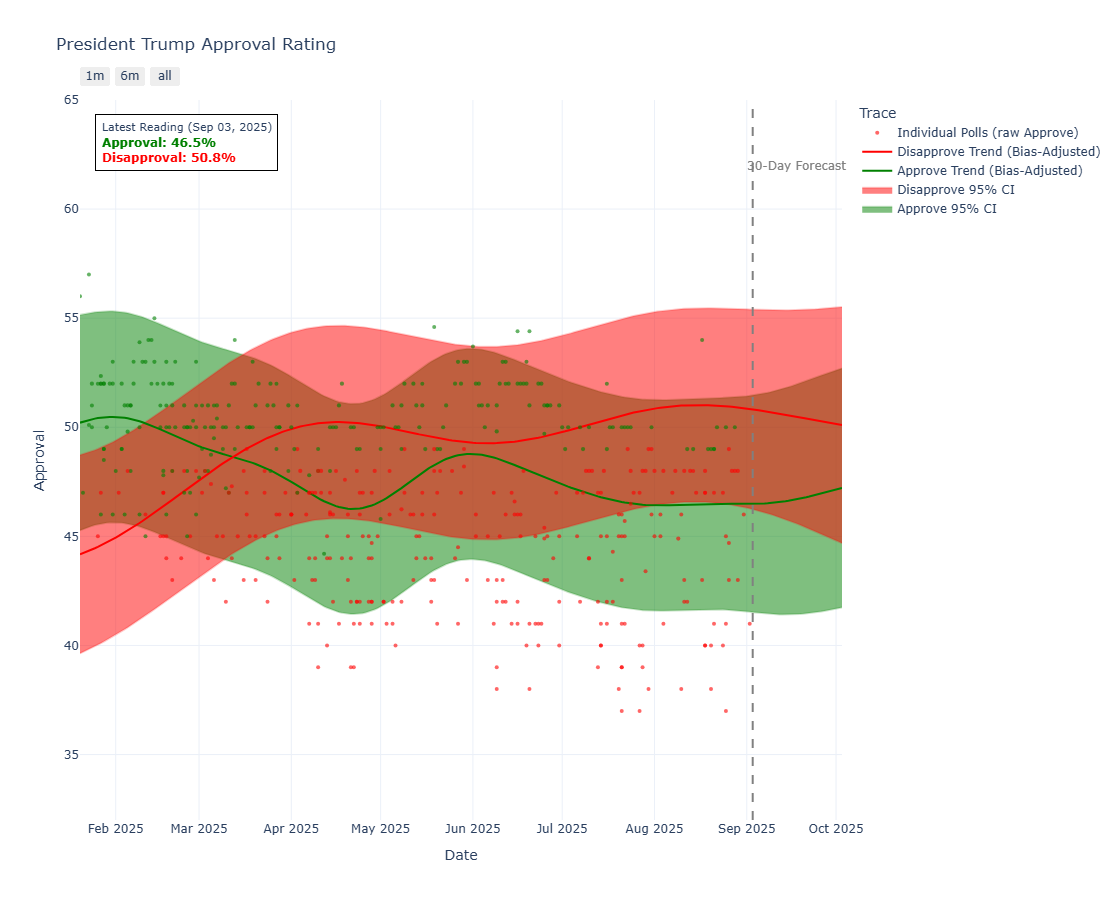

In [7]:
CURRENT_CSV = "current.csv"
CHART_TITLE = "President Trump Approval Rating"

run_pipeline()

#### As we can see with the above, President Trump started his term with a positive approval raiting. Over the course of the Spring, that changed pretty drasticallywith his approval bottoming out around 46.3 and a disapproval of 50.2. His approval went back up in late Spring/early Summer. Recently his approval has been on the rise and the model's forecast shows this getting closer over the next 30 days. 

## Immigration

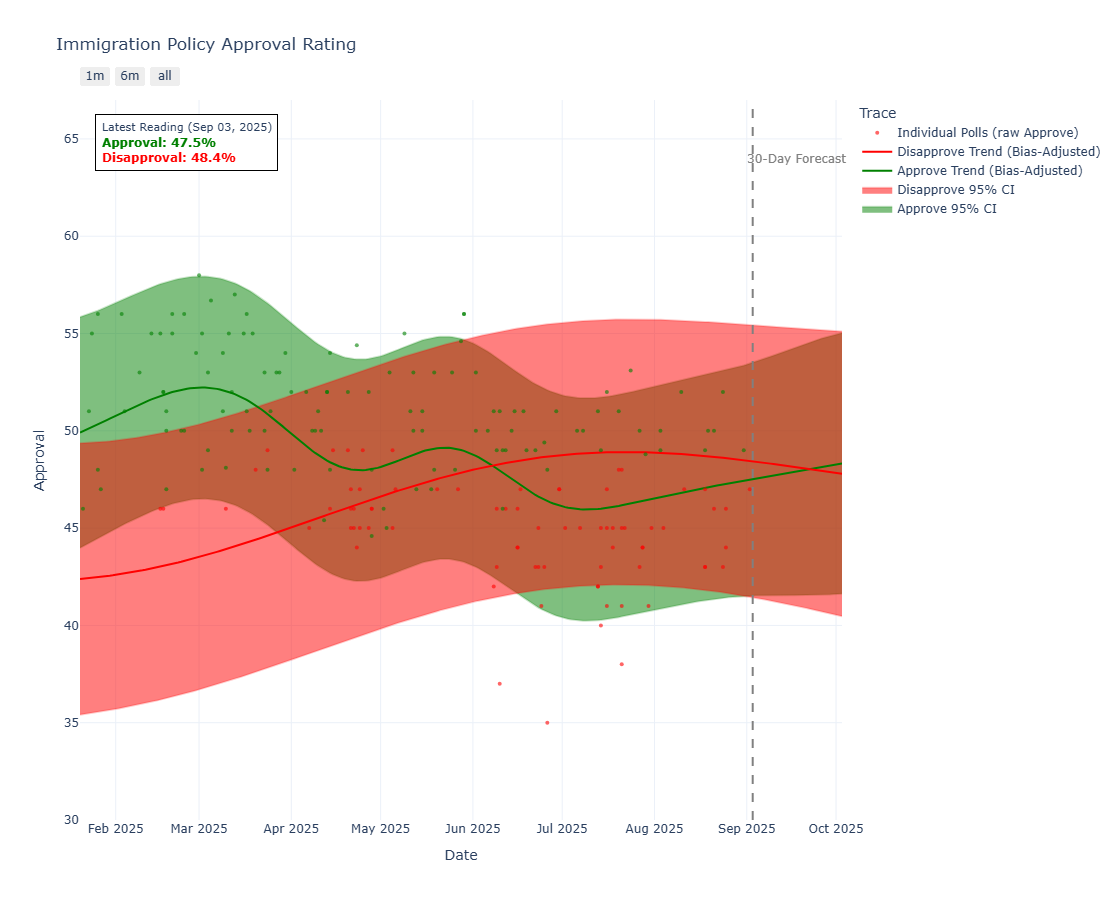

In [8]:
CURRENT_CSV = "immigration.csv"
CHART_TITLE = "Immigration Policy Approval Rating"

run_pipeline()

#### President Trump's strongest policy position has been immigration. He started his term with a positive approval raiting and then saw a big drop with the Kilmar Abrego Garcia case and the riots in Los Angelas. Recently, as more information has come out, his immigration policy has again become more popular. Our predictive model shows that the policies might go back to being a net approval within the next 30 days, if they stay with the current tradjectory. 

## Economy

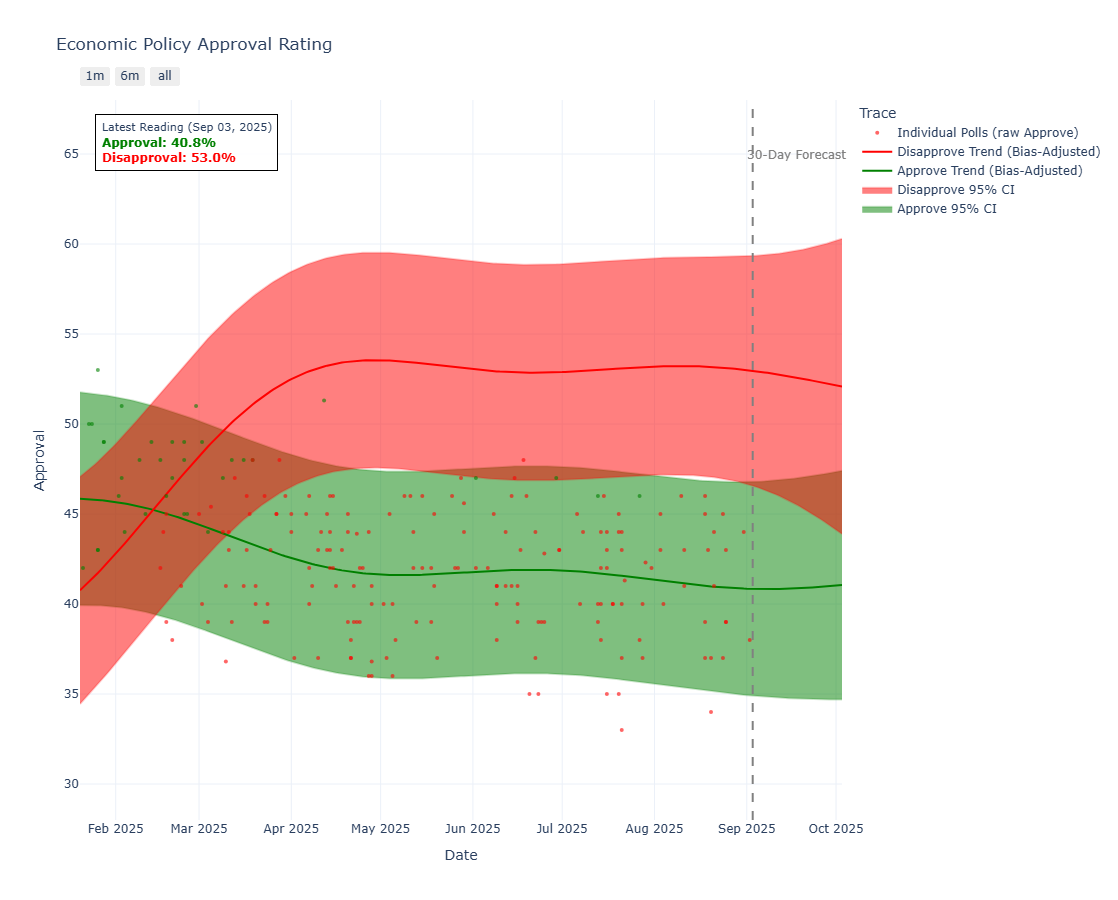

In [9]:
CURRENT_CSV = "economy.csv"
CHART_TITLE = "Economic Policy Approval Rating"

run_pipeline()

#### President Trump's economic policy has never been overly popular, never having approval above 45.8%. Like most of his polling numbers, this approval on the economy slid over the spring, as his honeymoon wayned. His numbers here have been remarkably steady.

## Trade

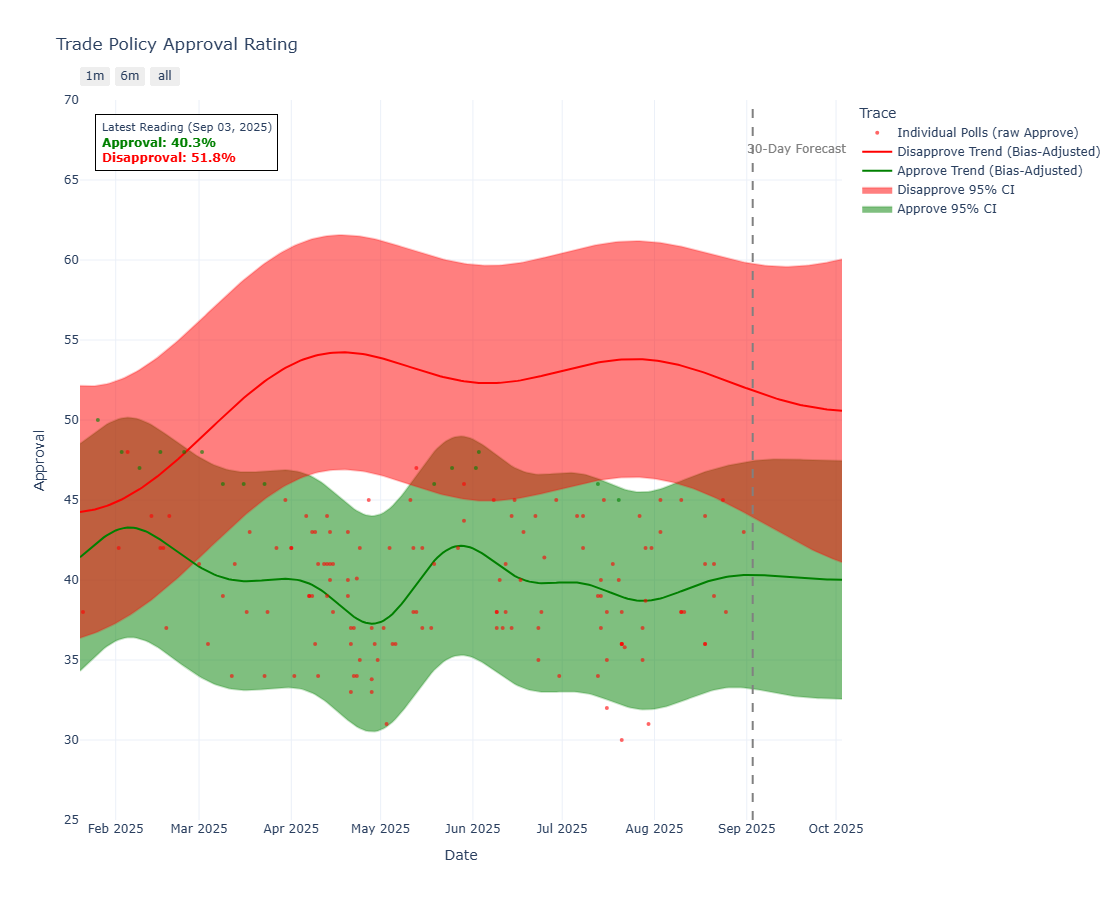

In [10]:
CURRENT_CSV = "trade.csv"
CHART_TITLE = "Trade Policy Approval Rating"

run_pipeline()

#### Starting with a negative polling on trade policy was not a good look, and it's never really gotten any better. President Trump has bucked tradition, and defied economists with his trade wars and tarrifs. Even though he's brought in several massive trade deals and June saw the first monthly surpluss for the government in 20 years, his trade polling has always been horrible. Analysis needs to be done on the effects of the media in polling of these policies.

## Inflation

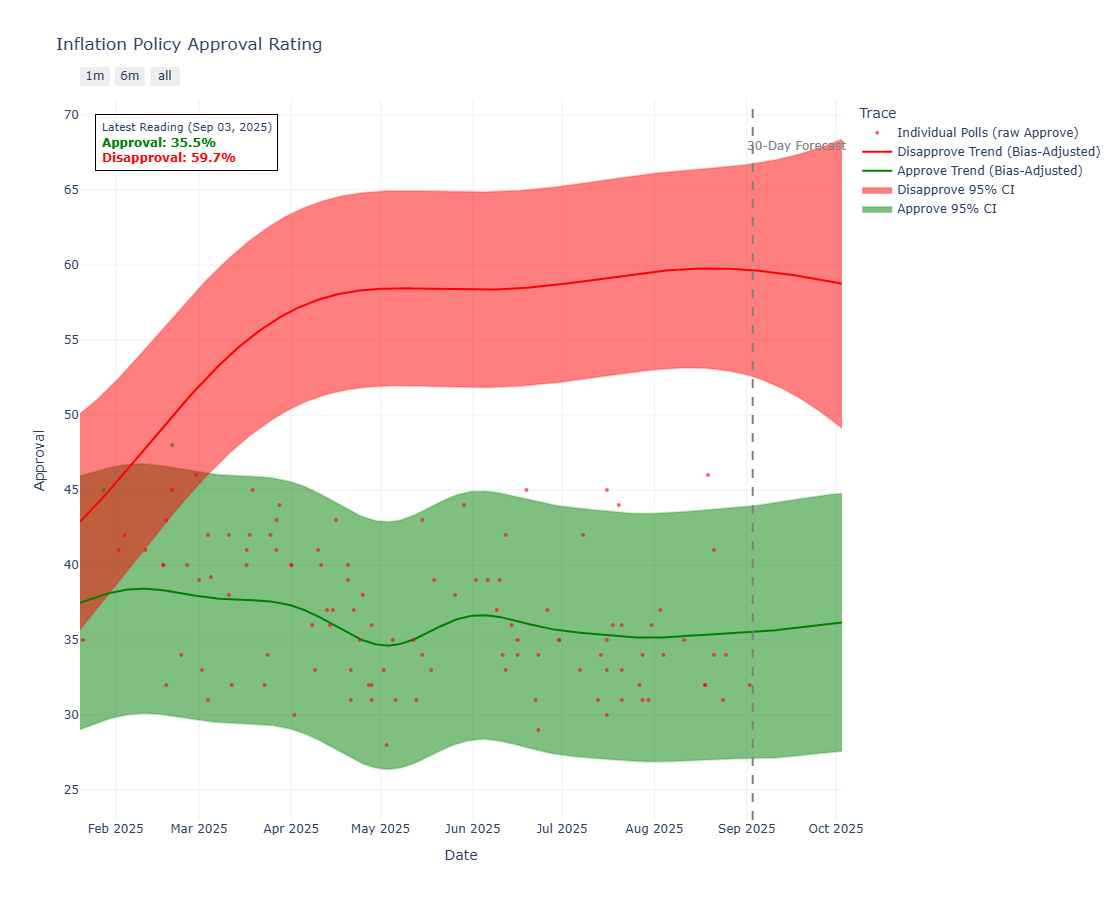

In [11]:
CURRENT_CSV = "inflation.csv"
CHART_TITLE = "Inflation Policy Approval Rating"

run_pipeline()

#### From day 1, the media hammered President Trump on 'egg prices' even though they had gone up under President Biden. Prices on food items and fuel have come down significantly over the last six months, even with inflation at about 2%.